# LSTM Baseline Model Testing

## 0 Imports & Constants

In [83]:
import sys
import os

# Füge das übergeordnete Verzeichnis zu sys.path hinzu
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.insert(0, parent_dir)

In [84]:
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
from torch.utils.data import DataLoader

from utils.utils import load_time_series, add_lagged_data, scale_data, train_test_split_to_tensor
from utils.TimeSeriesDataset import TimeSeriesDataset

from baseline_model.LSTM import LSTM

In [85]:
DATA_FOLDER = Path("../data")
MULTIVARIATE_DATA_FOLDER = DATA_FOLDER / "multivariate"
UNIVARIATE_DATA_FOLDER = DATA_FOLDER / "univariate"
BATCH_SIZE = 16
LEARNING_RATE = 0.001
NUM_EPOCHS = 170

In [86]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

## 2 Data

### Load Data

In [87]:
# Load data from csv
# -> convert Date column to datetime

df = load_time_series(f'{UNIVARIATE_DATA_FOLDER}/NVDA_open_high_low_close_adjClose_volume_99_24.csv')
df = df[['Close', 'Date']]
df

,Close,Date
0,0.041016,1999-01-22
1,0.045313,1999-01-25
2,0.041797,1999-01-26
3,0.041667,1999-01-27
4,0.041536,1999-01-28
...,...,...
6386,121.790001,2024-06-10
6387,120.910004,2024-06-11
6388,125.199997,2024-06-12
6389,129.610001,2024-06-13


### Data Preprocessing

In [88]:
lookback = 7
shifted_np_array = add_lagged_data(df, lookback)
shifted_np_array

array([[3.72400000e-02, 4.03650000e-02, 3.95830000e-02, ...,
        4.17970000e-02, 4.53130000e-02, 4.10160000e-02],
       [3.80210000e-02, 3.72400000e-02, 4.03650000e-02, ...,
        4.16670000e-02, 4.17970000e-02, 4.53130000e-02],
       [4.01040000e-02, 3.80210000e-02, 3.72400000e-02, ...,
        4.15360000e-02, 4.16670000e-02, 4.17970000e-02],
       ...,
       [1.25199997e+02, 1.20910004e+02, 1.21790001e+02, ...,
        1.22440002e+02, 1.16436996e+02, 1.15000000e+02],
       [1.29610001e+02, 1.25199997e+02, 1.20910004e+02, ...,
        1.20998001e+02, 1.22440002e+02, 1.16436996e+02],
       [1.31880005e+02, 1.29610001e+02, 1.25199997e+02, ...,
        1.20888000e+02, 1.20998001e+02, 1.22440002e+02]])

In [89]:
scaler = MinMaxScaler(feature_range=(-1, 1))
shifted_np_array = scale_data(shifted_np_array, scaler)
shifted_np_array

array([[-0.9999526 , -0.99990353, -0.99991263, ..., -0.99987448,
        -0.99981703, -0.99988724],
       [-0.99994075, -0.99995177, -0.99990013, ..., -0.99987661,
        -0.99987448, -0.99981703],
       [-0.99990915, -0.99993971, -0.99995007, ..., -0.99987875,
        -0.99987661, -0.99987448],
       ...,
       [ 0.89866945,  0.8657158 ,  0.94551237, ...,  1.        ,
         0.90191638,  0.87843719],
       [ 0.9655658 ,  0.93193172,  0.93145108, ...,  0.97643903,
         1.        ,  0.90191638],
       [ 1.        ,  1.        ,  1.        , ...,  0.97464171,
         0.97643903,  1.        ]])

In [90]:
X_train, y_train, X_test, y_test = train_test_split_to_tensor(shifted_np_array, lookback)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


(torch.Size([6064, 7, 1]),
 torch.Size([6064, 1]),
 torch.Size([320, 7, 1]),
 torch.Size([320, 1]))

In [91]:
train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [92]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [93]:
# Visualize size of batches
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 1]) torch.Size([16, 1])


## 3 Model, Optimizer, Criterion

In [94]:
model = LSTM(
    input_size=1,
    hidden_size=4,
    num_stacked_layers=1,
    device=device
).to(device)

In [95]:
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

## 4 Train Test Loop

In [96]:
def train_one_epoch(epoch):
    model.train()
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = criterion(output, y_batch)
        running_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 0:
            avg_loss_across_batches = running_loss / 100
            print(f'Batch: {batch_index}, Loss: {avg_loss_across_batches}')
            running_loss = 0.0

In [97]:
def validate_one_epoch():
    model.eval()
    running_loss = 0.0

    for _, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.inference_mode():
            output = model(x_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print(f'Validation Loss: {avg_loss_across_batches}')
    print('*' * 50)

In [98]:
for epoch in range(NUM_EPOCHS):
    print(f'Epoch: {epoch + 1}')
    train_one_epoch(epoch)
    validate_one_epoch()

Epoch: 1
Batch: 0, Loss: 0.005738202333450317
Batch: 100, Loss: 0.3992110234498978
Batch: 200, Loss: 0.17567314498126507
Batch: 300, Loss: 0.03729522514156997
Validation Loss: 0.6105290453881025
**************************************************
Epoch: 2
Batch: 0, Loss: 3.6338584031909704e-05
Batch: 100, Loss: 0.006480217125499621
Batch: 200, Loss: 0.008505508791422471
Batch: 300, Loss: 0.005715158006642014
Validation Loss: 0.5383030034601688
**************************************************
Epoch: 3
Batch: 0, Loss: 2.2612367756664754e-05
Batch: 100, Loss: 0.006283488245680928
Batch: 200, Loss: 0.006190608447650447
Batch: 300, Loss: 0.0048718379583442585
Validation Loss: 0.4134918596595526
**************************************************
Epoch: 4
Batch: 0, Loss: 1.0031742276623844e-05
Batch: 100, Loss: 0.003988171034725383
Batch: 200, Loss: 0.002320839195599547
Batch: 300, Loss: 0.0006729416090456653
Validation Loss: 0.247849884419702
************************************************

## 5 Plot Predictions

### Inverse Transform

In [99]:
with torch.inference_mode(): 
    test_pred = model(X_test.to(device)).to('cpu').detach().numpy()
    train_pred = model(X_train.to(device)).to('cpu').detach().numpy()

In [100]:
test_pred = test_pred.flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_pred
dummies = scaler.inverse_transform(dummies)

test_pred = dc(dummies[:, 0])
test_pred

array([23.99778522, 23.67721216, 23.22942756, 23.07366171, 23.78766516,
       24.16434882, 25.18062652, 25.63863912, 25.87711703, 26.13095462,
       26.38246607, 26.94685697, 26.84849446, 26.62468861, 26.4576024 ,
       26.79502829, 27.19057265, 27.5868243 , 27.83340445, 27.55214024,
       27.05302703, 26.98879847, 27.35246431, 27.21069467, 26.69836717,
       26.498593  , 26.64547861, 26.87604288, 27.40793836, 27.76097148,
       27.30269169, 27.1344149 , 27.03008376, 26.46179498, 26.75807702,
       27.06379728, 27.52375881, 28.45425173, 28.27902006, 27.90735413,
       27.60615259, 28.26797869, 28.82511215, 28.61059127, 28.72337829,
       28.55018986, 28.32762567, 28.66837969, 28.96854782, 29.71070874,
       30.94612819, 31.05204677, 30.97794777, 30.60507162, 30.37530107,
       35.21492676, 37.32055953, 38.53275282, 37.39351314, 38.1385955 ,
       38.10773074, 37.98591809, 37.62775721, 36.78889785, 37.17627121,
       37.48925676, 38.0251012 , 39.11532859, 40.60026536, 40.80

In [101]:
train_pred = train_pred.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_pred
dummies = scaler.inverse_transform(dummies)

train_pred = dc(dummies[:, 0])
train_pred

array([-1.32725235e-02, -1.52293217e-02, -1.54886564e-02, ...,
        2.37389928e+01,  2.36874755e+01,  2.34699526e+01])

In [102]:
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([ 0.0372388 ,  0.03802074,  0.04010327, ..., 23.55400067,
       23.28800184, 24.18100126])

In [103]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([ 23.43599945,  22.96500047,  22.96599851,  24.06300004,
        24.22799978,  25.5409996 ,  25.72500151,  25.90000135,
        26.19899855,  26.46799937,  27.19100095,  26.77900062,
        26.53099805,  26.40999877,  26.98400077,  27.38299901,
        27.77699915,  27.9650011 ,  27.45299973,  26.88100167,
        27.03699936,  27.57900103,  27.16900072,  26.49500161,
        26.46299735,  26.75799844,  27.00200096,  27.66700194,
        27.93100074,  27.10399809,  27.1190002 ,  27.04200137,
        26.24099898,  26.95600048,  27.22599935,  27.74900279,
        28.91000104,  28.20999774,  27.80200137,  27.56199889,
        28.67999867,  29.15099764,  28.5709995 ,  28.88499882,
        28.57799761,  28.33999908,  28.95299952,  29.21299828,
        30.17799844,  31.67799824,  31.26400181,  31.1760009 ,
        30.68799979,  30.53799823,  37.98000054,  38.94599874,
        40.11100097,  37.83399903,  39.7699994 ,  39.32700072,
        39.17100107,  38.65399965,  37.47499728,  38.50

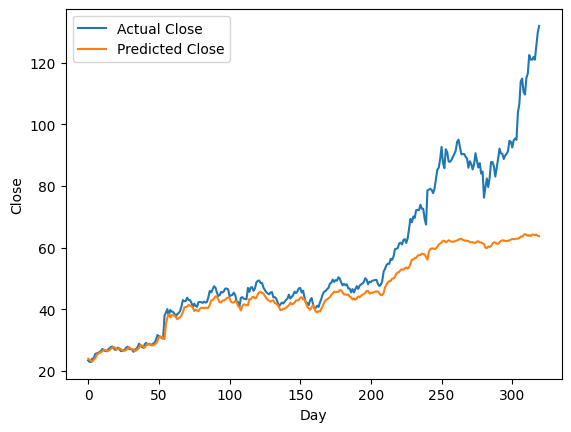

In [104]:
# plot test data

plt.plot(new_y_test, label="Actual Close")
plt.plot(test_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()


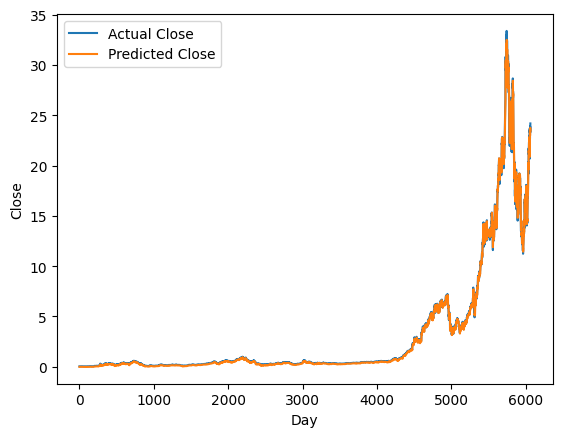

In [105]:
# plot train data

plt.plot(new_y_train, label="Actual Close")
plt.plot(train_pred, label="Predicted Close")
plt.xlabel("Day")
plt.ylabel("Close")
plt.legend()
plt.show()
